Using TensorFlow backend.


UMPM


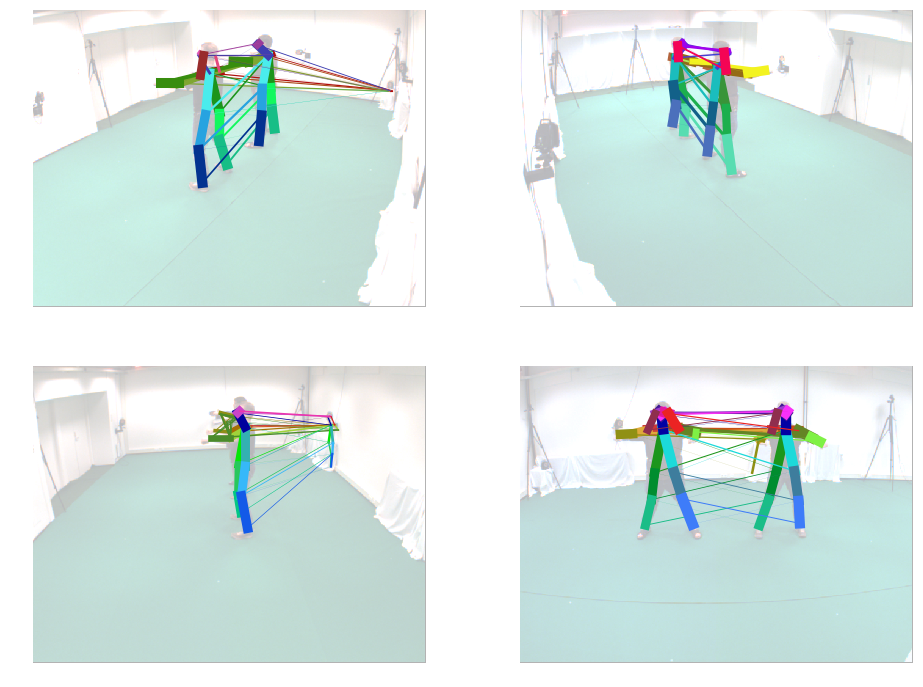

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.append('./../../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../../')
import mvpose.data.transform as tfm
import mvpose.geometry.geometry as gm
from mvpose.geometry import stereo
import mvpose.pose_estimation.heatmaps as mvhm
from mvpose.candidates import peaks as mvpeaks
import mvpose.pose_estimation.part_affinity_fields as mvpafs
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_MAP_IDX

root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()


from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)

Im = np.array([X[0][0], X[1][0], X[2][0], X[3][0]])
with_gpu = False

if with_gpu:
    _start = time()
    heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
    _end = time(); print('elapsed:', _end - _start)
else:
    if isfile('/tmp/heatmaps.npy') and isfile('/tmp/pafs.npy'):
        heatmaps = np.load('/tmp/heatmaps.npy')
        pafs = np.load('/tmp/pafs.npy')
    else:
        heatmaps = []; pafs = []
        for im in Im:
            _start = time()
            hm, paf = pe.predict_pafs_and_heatmaps(im)
            heatmaps.append(np.squeeze(hm))
            pafs.append(np.squeeze(paf))
            _end = time()
            print('elapsed:', _end - _start)
        heatmaps = np.array(heatmaps)
        pafs = np.array(pafs)
        np.save('/tmp/heatmaps.npy', heatmaps)
        np.save('/tmp/pafs.npy', pafs)
        
import mvpose.plot.limbs as pltlimbs

fig = plt.figure(figsize=(16,12))

Calib_undist = []
Peaks_undist = []
Peaks = []
Limb_Weights = []

for cid, cam in enumerate(Calib):
    hm = heatmaps[cid]
    paf = pafs[cid]
    peaks = mvhm.get_all_peaks(hm)
    Peaks.append(peaks)
    limbs = mvpafs.calculate_limb_weights(peaks, paf)
    Limb_Weights.append(limbs)
    ax = fig.add_subplot(2,2,cid+1)
    pltlimbs.plot(ax, Im[cid], peaks, limbs); ax.axis('off')
    
    K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
    hm_ud, K_new = gm.remove_distortion(hm, cam)
    h,w,_ = hm.shape
    mapx, mapy = \
        cv2.initUndistortRectifyMap(
            K, distCoef, None, K_new, (w, h), 5)
    peaks_undist = mvpeaks.Peaks.undistort(peaks, mapx, mapy)
    Peaks_undist.append(peaks_undist)
    
    assert peaks_undist.n_joints == peaks.n_joints
    for __k in range(peaks_undist.n_joints):
        p1 = peaks[__k]
        p2 = peaks_undist[__k]
        assert p1.shape == p2.shape, 'k:' + str(__k)
    
    Calib_undist.append({
        'K': K_new,
        'distCoeff': 0,
        'rvec': rvec,
        'tvec': tvec
    })
    
plt.show()

0 -> 1
0 -> 2
0 -> 3
1 -> 2
1 -> 3
2 -> 3


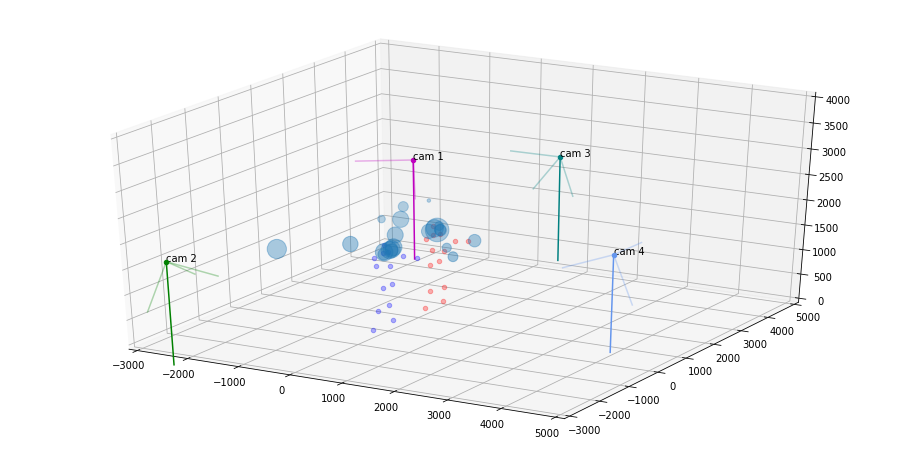

In [2]:
n_cameras = len(Calib)

all_peaks3d = None

for cam1 in range(n_cameras-1):
    K1, rvec1, tvec1, distCoef1 = \
        gm.get_camera_parameters(Calib_undist[cam1])
    assert distCoef1 == 0
    
    peaks1 = Peaks_undist[cam1]
    
    for cam2 in range(cam1+1, n_cameras):
        # ---------------------------------------
        print(str(cam1) + ' -> ' + str(cam2))
        # ---------------------------------------
        K2, rvec2, tvec2, distCoef2 = \
            gm.get_camera_parameters(Calib_undist[cam2])
        assert distCoef2 == 0
        
        peaks2 = Peaks_undist[cam2]
        
        if all_peaks3d is None:
            all_peaks3d = stereo.triangulate(peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2)[0]
        else:
            all_peaks3d.merge(
                stereo.triangulate(peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2)[0])

            
# =========================================
#              --- plot ---
# =========================================

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-3000, 5000])
ax.set_ylim([-3000, 5000])
ax.set_zlim([0, 4000])


cam_color = ['m', 'g', 'teal', 'cornflowerblue']
for i,cam in enumerate(Calib):
    R = cv2.Rodrigues(np.array(cam['rvec']))[0]
    t = np.array(cam['tvec'])
    P = -np.transpose(R) @ t
    x,y,z = P
    ax.scatter(x,y,z, color=cam_color[i])
    ax.text(x,y,z, 'cam ' + str(i+1))
    ax.plot([x,x], [y,y], [0,z], color=cam_color[i])
    
    M = np.transpose(R.copy())
    base = M[:,0]
    yaxis = M[:,1]
    lookat = M[:,2]
    f = 1000
    
    for e in [lookat,yaxis,base]:
        p2 = P + e * f
        ax.plot([P[0], p2[0]], [P[1], p2[1]], [P[2], p2[2]], color=cam_color[i], alpha=0.3)


color = ['red', 'blue']
for x,y,z,pid in Y[0]:
    ax.scatter([x],[y],[z], color=color[int(pid)], alpha=0.3)

# ------- plot ---------
point3d = all_peaks3d[0]
if not point3d is None:
    pts = point3d[:,0:3]
    w = point3d[:,3]
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=1000*w)

plt.show()

## Mean shift

$$
y_{k+1} = y_k + m(y_k) = \frac{\sum_i x_i G(y_k - x_i)}{\sum_i G(y_k-x_i)}
$$

In [3]:
from scipy.spatial import KDTree
import mvpose.math as mvmath
from numba import jit, float64
from mvpose.algorithm import meanshift

cage_x = [-2000, 4000]
cage_y = [-3000, 5000]
cage_z = [    0, 3500]

data = all_peaks3d.data[0]
print('total data:', data.shape)

mask = (data[:,0] > cage_x[0]) * 1 * (data[:,0] < cage_x[1])
mask *= (data[:,1] > cage_y[0]) * 1 * (data[:,1] < cage_y[1])
mask *= (data[:,2] > cage_z[0]) * 1 * (data[:,2] < cage_z[1])

data = data[mask.nonzero()]
print('data in cage:', data.shape)
print('--')


sigma = float(200)
y_0 = np.array((300, 1200, 1600), 'float64')


_start = time()
center = meanshift.meanshift(y_0, data, sigma)
_end = time() 
print('elapsed:', _end - _start)

print(center)

total data: (24, 4)
data in cage: (22, 4)
--
elapsed: 0.0052678585052490234
[ 228.03084222 1243.11775285 1677.62940095]


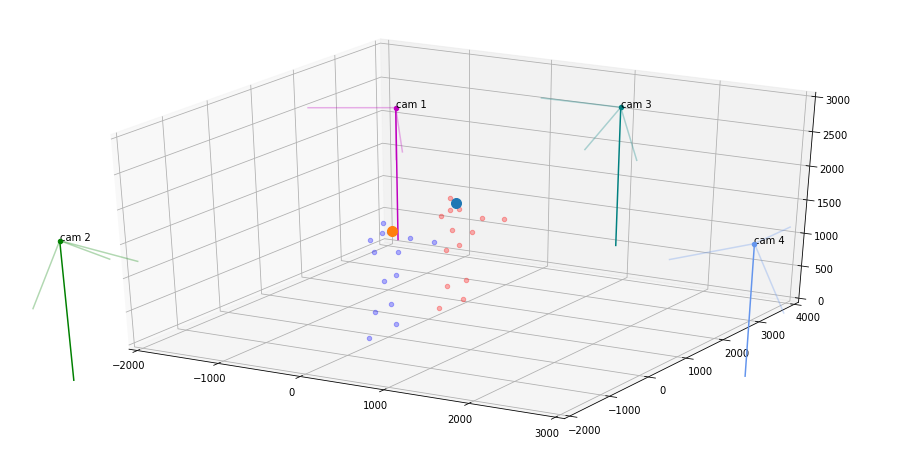

In [4]:
Modes, Peaks = meanshift.find_all_modes(data, sigma)

# =========================================
#              --- plot ---
# =========================================

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-2000, 3000])
ax.set_ylim([-2000, 4000])
ax.set_zlim([0, 3000])


cam_color = ['m', 'g', 'teal', 'cornflowerblue']
for i,cam in enumerate(Calib):
    R = cv2.Rodrigues(np.array(cam['rvec']))[0]
    t = np.array(cam['tvec'])
    P = -np.transpose(R) @ t
    x,y,z = P
    ax.scatter(x,y,z, color=cam_color[i])
    ax.text(x,y,z, 'cam ' + str(i+1))
    ax.plot([x,x], [y,y], [0,z], color=cam_color[i])
    
    M = np.transpose(R.copy())
    base = M[:,0]
    yaxis = M[:,1]
    lookat = M[:,2]
    f = 1000
    
    for e in [lookat,yaxis,base]:
        p2 = P + e * f
        ax.plot([P[0], p2[0]], [P[1], p2[1]], [P[2], p2[2]], color=cam_color[i], alpha=0.3)


color = ['red', 'blue']
for x,y,z,pid in Y[0]:
    ax.scatter([x],[y],[z], color=color[int(pid)], alpha=0.3)

# ------- plot ---------
for x,y,z in Modes:
    ax.scatter([x],[y],[z], s=100)

plt.show()

## End-to-End

Execute the whole algorithm

In [5]:
from mvpose.candidates.candidates import Candidates3d

candidates = Candidates3d()
candidates.triangulate(Peaks_undist, Limb_Weights, Calib_undist)

candidates.get_3d_points(3).shape

(18, 4)

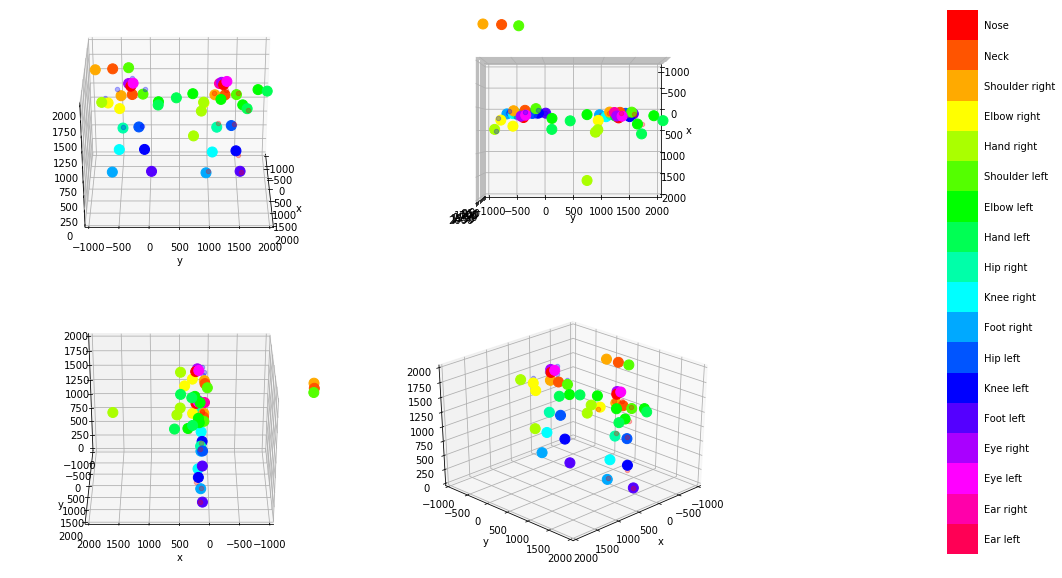

In [6]:
from cselect import color as cs
from mvpose.data.default_limbs import DEFAULT_JOINT_NAMES

n_cameras = len(Calib)

all_peaks3d = None

for cam1 in range(n_cameras-1):
    K1, rvec1, tvec1, distCoef1 = \
        gm.get_camera_parameters(Calib_undist[cam1])
    assert distCoef1 == 0
    
    peaks1 = Peaks_undist[cam1]
    
    for cam2 in range(cam1+1, n_cameras):
        K2, rvec2, tvec2, distCoef2 = \
            gm.get_camera_parameters(Calib_undist[cam2])
        assert distCoef2 == 0
        
        peaks2 = Peaks_undist[cam2]
        
        if all_peaks3d is None:
            all_peaks3d = stereo.triangulate(
                peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2)[0]
        else:
            all_peaks3d.merge(
                stereo.triangulate(
                    peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2)[0])

# =============================================
# PLOT
# =============================================
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(231, projection='3d'); ax.view_init(30, 0)
az = fig.add_subplot(232, projection='3d'); az.view_init(90, 0)
ax2 = fig.add_subplot(234, projection='3d'); ax2.view_init(30, 90)
az2 = fig.add_subplot(235, projection='3d'); az2.view_init(30, 45)

def set_cage(ax):
    ax.set_xlim([-1000, 2000])
    ax.set_ylim([-1000, 2000])
    ax.set_zlim([0, 2000])
    ax.set_xlabel('x');  ax.set_ylabel('y')

set_cage(ax)
set_cage(az)
set_cage(ax2)
set_cage(az2)

color = ['red', 'blue']
for x,y,z,pid in Y[0]:
    ax.scatter([x],[y],[z], color=color[int(pid)], alpha=0.3)
    az.scatter([x],[y],[z], color=color[int(pid)], alpha=0.3)
    ax2.scatter([x],[y],[z], color=color[int(pid)], alpha=0.3)
    az2.scatter([x],[y],[z], color=color[int(pid)], alpha=0.3)

# ------- plot ---------    

COLORS = colors = cs.lincolor(all_peaks3d.n_joints+1)
for k in range(all_peaks3d.n_joints):
    data = all_peaks3d[k]


    mask = (data[:,0] > cage_x[0]) * 1 * (data[:,0] < cage_x[1])
    mask *= (data[:,1] > cage_y[0]) * 1 * (data[:,1] < cage_y[1])
    mask *= (data[:,2] > cage_z[0]) * 1 * (data[:,2] < cage_z[1])

    data = data[mask.nonzero()]
    
    sigma = float(200)
    Modes, Peaks = meanshift.find_all_modes(data, sigma)
    if len(Modes) > 0:
        ax.scatter(Modes[:,0], Modes[:,1], Modes[:,2], color=COLORS[k]/255, s=100, alpha=1)
        az.scatter(Modes[:,0], Modes[:,1], Modes[:,2], color=COLORS[k]/255, s=100, alpha=1)
        ax2.scatter(Modes[:,0], Modes[:,1], Modes[:,2], color=COLORS[k]/255, s=100, alpha=1)
        az2.scatter(Modes[:,0], Modes[:,1], Modes[:,2], color=COLORS[k]/255, s=100, alpha=1)


    
ay = fig.add_subplot(133)

C = np.zeros((all_peaks3d.n_joints*100, 100, 3))
for k in range(all_peaks3d.n_joints):
    C[k*100:(k+1)*100,:,:] = COLORS[k]/255
    ay.text(120, k*100 + 60, DEFAULT_JOINT_NAMES[k])
    

ay.imshow(C)
ay.axis('off')

plt.show()